In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input/brain-tumor-object-detection-datasets'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import shutil
import random
!pip install ultralytics
import ultralytics
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO
import wandb
wandb.init(mode="disabled")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 723.1/723.1 kB 19.2 MB/s eta 0:00:00


In [3]:
if os.path.exists('dataset'):
    shutil.rmtree('dataset')
shutil.copytree('/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class', 'dataset')

'dataset'

In [4]:
files = os.listdir('dataset/images/train')
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]
print(random_file)


00176_98


Nhãn lớp: 0
Tọa độ tâm (x, y): 0.694053 0.586854
Chiều rộng: 0.203443
Chiều cao: 0.220657


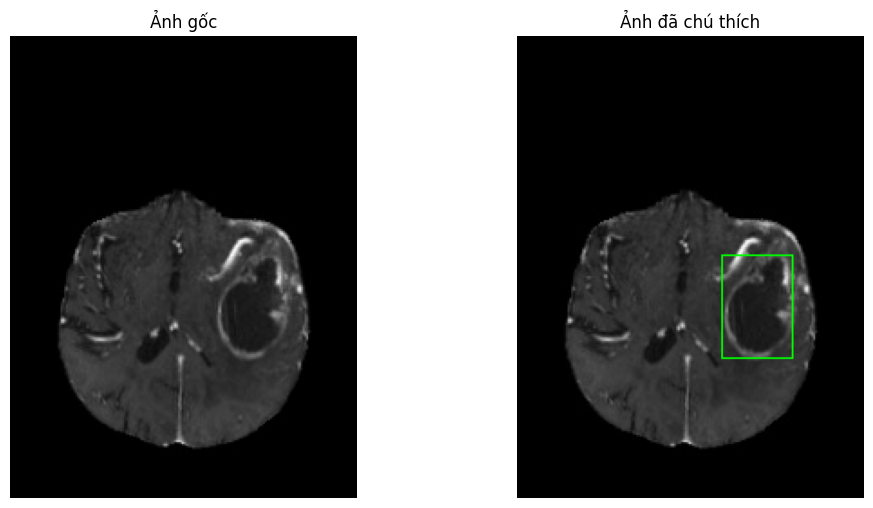

In [5]:
with open(os.path.join('dataset/labels/train', f'{random_file}.txt'), 'r') as f:
    labels = f.readline().split(' ')

# In thông tin của nhãn
print("Nhãn lớp:", int(labels[0]))
print("Tọa độ tâm (x, y):", float(labels[1]), float(labels[2]))
print("Chiều rộng:", float(labels[3]))
print("Chiều cao:", float(labels[4]))

# Đọc và xử lý hình ảnh
img = cv2.imread(os.path.join('dataset/images/train', f'{random_file}.jpg'), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Sao chép hình ảnh 
annotated_img = img.copy()

# Xác định vị trí và kích thước của hình chữ nhật
tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])

# Xác định màu sắc của hình chữ nhật dựa trên loại u
if tumor_class == 1:
    colour = (255, 0, 0)  # Màu đỏ
else:
    colour = (0, 255, 0)  # Màu xanh lá cây

# Vẽ hình chữ nhật trên hình ảnh được sao chép
cv2.rectangle(annotated_img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

# Hiển thị hình ảnh gốc và hình ảnh đã được chú thích
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img)
axes[0].set_title('Ảnh gốc')
axes[0].axis('off')
axes[1].imshow(annotated_img)
axes[1].set_title('Ảnh đã chú thích')
axes[1].axis('off')
plt.show()


In [6]:
# Lấy danh sách tất cả các tệp tin ảnh trong thư mục train và test
train_images = os.listdir('dataset/images/train')
test_images = os.listdir('dataset/images/test')

# Lấy danh sách tất cả các tệp tin nhãn trong thư mục train và test
train_labels = os.listdir('dataset/labels/train')
test_labels = os.listdir('dataset/labels/test')

# Đếm số lượng ảnh và nhãn trong tập train và tập test
num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

#In số lượng ảnh và nhãn trong train và test
print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

310 75
296 75


In [7]:
# Xử lý dữ liệu: Loại bỏ các ảnh không có nhãn tương ứng từ tập huấn luyện
os.path.splitext(random_file)[0]
unlabelled = set(train_images) - set([os.path.splitext(file)[0] + '.jpg' for file in train_labels])

#Xóa ảnh không có nhãn từ tập tương ứng
for image in unlabelled:
    os.remove(os.path.join('dataset/images/train', image))


In [8]:
# Lấy danh sách tất cả các tệp tin ảnh trong thư mục train và test
train_images = os.listdir('dataset/images/train')
test_images = os.listdir('dataset/images/test')

# Lấy danh sách tất cả các tệp tin nhãn trong thư mục train và test
train_labels = os.listdir('dataset/labels/train')
test_labels = os.listdir('dataset/labels/test')

# Đếm số lượng ảnh và nhãn trong tập train và tập test
num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

#In số lượng ảnh và nhãn trong train và test
print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

296 75
296 75


In [9]:
# Tính toán số lượng ảnh cho tập validation (20%)
val_split = int(num_train_images * 0.2)

# Lấy ngẫu nhiên các ảnh cho tập validation
val_images = random.sample(train_images, val_split)

# Kiểm tra và xóa thư mục validation nếu tồn tại
if os.path.exists('dataset/images/val'):
    shutil.rmtree('dataset/images/val')
if os.path.exists('dataset/labels/val'):
    shutil.rmtree('dataset/labels/val')

# Tạo thư mục validation
os.makedirs('./dataset/images/val')
os.makedirs('./dataset/labels/val')

# Di chuyển các ảnh và nhãn tương ứng sang thư mục validation
for image in val_images:
    # Di chuyển ảnh sang thư mục validation
    shutil.move(os.path.join('dataset/images/train', image), 'dataset/images/val')
    # Tạo tên nhãn từ tên ảnh và di chuyển nhãn sang thư mục validation
    label = os.path.splitext(image)[0] + '.txt'
    shutil.move(os.path.join('dataset/labels/train', label), 'dataset/labels/val')

# Đếm số lượng ảnh trong thư mục validation sau khi chuyển
num_val_images = len(os.listdir('dataset/images/val'))

# Hiển thị số lượng ảnh trong tập validation
print("Số lượng ảnh trong tập validation:", num_val_images)

Số lượng ảnh trong tập validation: 59


In [10]:
text = """
path: /kaggle/working/dataset
train: images/train
val: images/val

# Classes
nc: 2
names: ['negative','positive']
"""
# Ghi nội dung của chuỗi vào tệp YAML
with open("./fixed_path.yaml", 'w') as file:
    file.write(text)

In [11]:
# import yaml

# # Đọc nội dung từ tệp YAML
# with open("./fixed_path.yaml", 'r') as file:
#     data = yaml.safe_load(file)

# # Hiển thị dữ liệu đã đọc
# print(data)


In [12]:
model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 214MB/s]


In [13]:
# Hiển thị thông tin về mô hình
print(model)


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [14]:
results = model.train(data='/kaggle/working/fixed_path.yaml', epochs=250, device=0)

Ultralytics YOLOv8.1.37 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/fixed_path.yaml, epochs=250, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

100%|██████████| 755k/755k [00:00<00:00, 26.4MB/s]
2024-03-29 16:02:18,229	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-03-29 16:02:19,218	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-03-29 16:02:21.497021: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 16:02:21.497132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 16:02:21.631918: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS facto

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 120MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/labels/train... 237 images, 0 backgrounds, 0 corrupt: 100%|██████████| 237/237 [00:00<00:00, 1423.16it/s]

train: New cache created: /kaggle/working/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/dataset/labels/val... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<00:00, 1067.32it/s]

val: New cache created: /kaggle/working/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/250      4.67G      1.803      5.061      1.567         19        640: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all         59         62      0.436       0.43       0.34      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/250      4.78G      1.215      2.289      1.184         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]


                   all         59         62      0.473      0.492      0.404      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/250       4.8G      1.225      1.924      1.148         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.41it/s]


                   all         59         62       0.49      0.428       0.42      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/250      4.78G      1.171      1.467      1.129         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         59         62       0.79       0.35      0.434      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/250      4.78G      1.165      1.338      1.101         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         59         62      0.594     0.0132     0.0271     0.0104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/250      4.79G      1.144      1.264      1.143         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         59         62      0.602     0.0789     0.0403     0.0136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/250      4.79G      1.219      1.332      1.101         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]

                   all         59         62      0.396       0.27      0.175     0.0922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/250      4.79G      1.187      1.278      1.141         28        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


                   all         59         62      0.204      0.371      0.203     0.0996

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/250       4.8G      1.123      1.263       1.12         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         62      0.203      0.294      0.182      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/250      4.81G       1.15      1.168      1.103         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


                   all         59         62      0.305      0.466       0.33       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/250      4.79G      1.146       1.13      1.127         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         59         62      0.257      0.399      0.229      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/250      4.79G      1.133      1.123      1.121         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         62      0.475      0.476       0.43       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/250      4.78G      1.112      1.039      1.109         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         59         62      0.179        0.4      0.177      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/250       4.8G      1.073      1.123      1.104         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]


                   all         59         62      0.378      0.567      0.426      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/250      4.78G      1.081      1.043      1.084         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         59         62      0.302      0.239      0.193      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/250      4.79G      1.103      1.033      1.094         29        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         62      0.704      0.773      0.768       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/250      4.78G      1.062     0.9876       1.09         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         59         62      0.568       0.76      0.647      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/250       4.8G      1.126      1.215      1.084         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

                   all         59         62      0.743      0.657      0.703      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/250      4.79G      1.099      1.038      1.099         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         59         62      0.564      0.669      0.665      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/250      4.79G      1.053      1.018      1.078         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         59         62      0.786      0.505       0.59      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/250      4.78G      1.053      0.991      1.084         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         59         62      0.616       0.41       0.43      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/250      4.79G     0.9954     0.8601      1.039         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

                   all         59         62      0.729      0.703      0.783      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/250      4.79G      1.058      0.896      1.074         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

                   all         59         62      0.708      0.623      0.709      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/250      4.79G      1.048     0.8964      1.082         16        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         59         62      0.863      0.741      0.844      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/250      4.78G      1.002     0.8467      1.055         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         59         62      0.855      0.781       0.85      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/250      4.79G     0.9827     0.8825      1.025         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


                   all         59         62      0.716      0.677      0.761      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/250      4.79G      1.007     0.9036      1.038         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         59         62      0.732      0.737       0.79      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/250      4.79G       1.01     0.8976      1.051         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


                   all         59         62      0.731       0.82      0.874      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/250      4.79G     0.9428     0.8839     0.9975         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         62      0.555      0.661      0.664      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/250      4.79G     0.9801     0.8439      1.021         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

                   all         59         62      0.729      0.785      0.809      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/250      4.79G      1.011     0.8338      1.039         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         59         62      0.608      0.776      0.677      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/250      4.79G     0.9515     0.8166      1.014         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         59         62      0.763      0.747      0.763      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/250      4.78G      0.971     0.8686      1.038         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

                   all         59         62      0.625      0.898      0.813      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/250       4.8G     0.9433     0.8008      1.027         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         59         62      0.845      0.846      0.894      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/250      4.79G     0.9267     0.7847      1.037         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.24it/s]

                   all         59         62       0.85      0.769      0.856      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/250       4.8G     0.8909     0.7919     0.9849         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         62      0.722      0.849      0.884      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/250      4.78G     0.9189     0.8046      1.013         28        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]

                   all         59         62      0.921      0.852      0.927      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/250      4.79G     0.9401     0.7591      1.026         29        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         59         62      0.825      0.735      0.823       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/250       4.8G     0.9562     0.8462      1.033         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

                   all         59         62      0.641      0.774      0.714       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/250      4.79G     0.9546     0.8033      1.017         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         59         62      0.608       0.81        0.7      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/250      4.78G     0.9327     0.7615      1.035         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         59         62      0.874      0.765      0.831      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/250      4.79G     0.9145     0.6681     0.9987         31        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         59         62      0.754      0.699      0.798      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/250      4.78G     0.9962     0.7748      1.051         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         59         62      0.815      0.674      0.766      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/250      4.79G     0.9475     0.7555      1.023         14        640: 100%|██████████| 15/15 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

                   all         59         62      0.775      0.674      0.705      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/250      4.79G     0.9577      0.745      1.022         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         62      0.827      0.656      0.757      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/250      4.81G     0.9099     0.7109      1.008         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         59         62      0.557       0.68      0.662      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/250      4.78G     0.8955     0.6925     0.9997         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]

                   all         59         62      0.873      0.837      0.872      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/250      4.79G     0.8855     0.6728     0.9988         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

                   all         59         62      0.821      0.831      0.871      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/250      4.79G     0.8476     0.6415     0.9817         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         59         62      0.772      0.711      0.757      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/250       4.8G     0.9159     0.7622      1.013         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         62      0.729      0.863       0.87      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/250      4.78G     0.8617     0.7082     0.9958         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         59         62      0.782      0.768      0.819      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/250       4.8G     0.8657     0.6957     0.9957         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

                   all         59         62      0.833      0.818      0.876      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/250      4.78G     0.8912     0.7058     0.9999         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         59         62      0.909       0.77      0.908       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/250       4.8G     0.8718     0.6719     0.9764         28        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         59         62      0.834      0.748       0.86      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/250      4.79G     0.8985     0.7128      1.008         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]

                   all         59         62      0.825      0.859       0.87      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/250       4.8G     0.8782     0.7123      1.011         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         59         62        0.9      0.814      0.883       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/250      4.79G     0.8785     0.6561      1.012         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

                   all         59         62      0.687      0.728      0.698      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/250      4.81G     0.9077     0.6416      1.024         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         59         62      0.675      0.871      0.827      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/250       4.8G     0.8908     0.6501      1.005         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         59         62      0.767      0.798      0.855      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/250      4.81G     0.8222     0.5805     0.9853         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

                   all         59         62      0.813      0.809      0.879      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/250      4.78G     0.8122     0.5756     0.9654         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


                   all         59         62      0.859      0.671      0.782       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/250       4.8G     0.8643     0.5863     0.9905         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         59         62      0.705      0.683      0.764       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/250       4.8G     0.8427     0.5831     0.9808         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         59         62      0.813      0.884      0.893       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/250      4.79G     0.8473     0.6139     0.9716         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         59         62      0.702      0.745      0.731      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/250      4.79G     0.8279     0.5983     0.9733         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         59         62      0.751      0.725      0.769      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/250      4.81G     0.8164     0.6021     0.9473         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         62       0.92      0.754      0.875      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/250       4.8G     0.8025     0.6097     0.9768         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         59         62      0.809      0.795      0.866      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/250      4.79G     0.8058     0.5799     0.9641         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         59         62      0.713      0.715      0.767      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/250      4.79G     0.8499     0.6098     0.9832         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         59         62      0.837      0.788      0.866      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/250       4.8G     0.8345     0.5874      0.968         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         59         62      0.917      0.815      0.902      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/250      4.79G     0.8023     0.5622     0.9708         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         59         62      0.949      0.815      0.908      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/250       4.8G     0.7827     0.5683     0.9639         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         62      0.703      0.762      0.846      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/250      4.79G     0.8153       0.56     0.9622         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         62      0.834      0.783      0.884      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/250      4.79G     0.7401     0.5743     0.9346         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]

                   all         59         62      0.834      0.771      0.893      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/250       4.8G     0.8101     0.5473     0.9546         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         59         62      0.881      0.768      0.835       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/250      4.79G     0.7993     0.5434      0.965         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]

                   all         59         62      0.816      0.747      0.844      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/250      4.79G     0.8015     0.5443     0.9735         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         59         62      0.958       0.83      0.908      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/250       4.8G     0.8177     0.5749      0.964         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         62      0.695      0.728      0.793      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/250       4.8G     0.8111     0.5649     0.9913         16        640: 100%|██████████| 15/15 [00:04<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

                   all         59         62      0.929      0.776      0.917      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/250      4.79G     0.7608     0.5507      0.959         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.41it/s]

                   all         59         62      0.673       0.77      0.798      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/250      4.78G     0.7871     0.5266     0.9574         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]

                   all         59         62      0.814      0.804      0.865      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/250       4.8G     0.7898     0.5419     0.9636         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         62       0.83      0.765      0.783       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/250       4.8G     0.8037     0.5439     0.9719         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         62      0.811      0.836      0.856      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/250      4.78G     0.7159      0.496     0.9242         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.31it/s]

                   all         59         62      0.728      0.823      0.879      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/250      4.78G     0.7578     0.5245     0.9509         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         59         62      0.768      0.811      0.871      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/250       4.8G     0.7894     0.5526     0.9717         34        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         59         62      0.886      0.809      0.879      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/250       4.8G     0.7757     0.5486     0.9556         15        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

                   all         59         62      0.909      0.798      0.905      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/250      4.79G     0.7432     0.5646     0.9622         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         59         62      0.778      0.795      0.845      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/250      4.79G     0.7629     0.5501     0.9537         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         62      0.867      0.787      0.854      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/250      4.79G     0.7506     0.5207     0.9246         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         59         62      0.918      0.788        0.9      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/250      4.79G     0.7607       0.52     0.9622         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         59         62      0.901      0.822      0.911      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/250       4.8G     0.7573     0.5185     0.9564         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         59         62      0.923       0.83      0.913      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/250      4.79G     0.7053      0.473     0.9397         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         59         62      0.788      0.867      0.872      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/250      4.79G     0.7297     0.5115     0.9438         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

                   all         59         62      0.902      0.795      0.888      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/250      4.78G     0.7293     0.5082     0.9339         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         62      0.867      0.819      0.892      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/250      4.79G     0.7598     0.4669     0.9526         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]

                   all         59         62      0.836      0.811      0.856      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/250      4.78G     0.7316     0.4837     0.9317         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

                   all         59         62      0.835      0.821      0.881      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/250       4.8G     0.7643      0.494     0.9673         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.80it/s]

                   all         59         62      0.774      0.887      0.877      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/250      4.78G     0.7378     0.5157     0.9568         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         59         62      0.901      0.827      0.893      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/250       4.8G     0.7219     0.4716     0.9488         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]

                   all         59         62      0.785      0.791      0.857      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/250      4.78G      0.714     0.4712     0.9218         34        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         62      0.922      0.856      0.909      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/250      4.81G     0.7007     0.4921     0.9208         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         59         62      0.918      0.851      0.909      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/250      4.78G     0.6789     0.4659     0.9026         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         59         62      0.881      0.853      0.915      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/250      4.79G     0.6645     0.4495     0.9214         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         59         62      0.907      0.808      0.903      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/250      4.78G     0.6817     0.4972      0.928         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         59         62       0.79      0.895      0.921      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/250       4.8G     0.7102     0.4897     0.9259         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         59         62      0.728      0.659      0.792      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/250      4.78G     0.6336     0.4658      0.906         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         59         62      0.793      0.838      0.897      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/250      4.78G     0.6802     0.4724     0.9269         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         59         62       0.91      0.777      0.878      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/250      4.78G     0.7007     0.4709     0.9178         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]


                   all         59         62      0.916      0.815      0.916      0.684

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/250       4.8G     0.6962     0.4564     0.9078         31        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         59         62      0.886      0.789      0.874      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/250       4.8G     0.7096     0.4477     0.9424         28        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         59         62        0.9      0.781      0.907      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/250       4.8G     0.6661     0.4424     0.9251         28        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         59         62      0.728      0.872      0.854       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/250      4.79G     0.6561     0.4442     0.9184         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         59         62      0.919      0.789      0.884      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/250       4.8G     0.6576     0.4425     0.9147         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         59         62      0.878      0.872      0.932      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/250       4.8G     0.6555     0.4464     0.9192         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         59         62      0.885      0.883      0.928      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/250      4.81G     0.6443     0.4472      0.905         37        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

                   all         59         62      0.882      0.799      0.898      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/250      4.79G     0.6556     0.4463     0.9153         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


                   all         59         62      0.938      0.822      0.926       0.69

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/250      4.81G     0.6741     0.4625     0.9297         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

                   all         59         62      0.809      0.869      0.883      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/250      4.78G     0.6545     0.4555     0.9022         34        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]

                   all         59         62      0.872      0.768      0.879      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/250      4.79G     0.6587     0.4523     0.9171         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         59         62      0.846      0.886      0.899      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/250      4.79G     0.6538     0.4425     0.9043         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         59         62      0.923      0.856      0.904       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/250      4.79G     0.6765     0.4461     0.9218         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         59         62      0.871      0.773      0.804      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/250      4.78G     0.6423     0.4266     0.9102         34        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]

                   all         59         62      0.889      0.796      0.868      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/250      4.79G     0.6501     0.4246     0.9057         16        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         59         62      0.931      0.804      0.909      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/250      4.79G     0.6187     0.4227      0.918         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         59         62      0.863      0.882      0.915      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/250       4.8G     0.6402     0.3978     0.9018         16        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         59         62      0.837      0.759      0.817      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/250       4.8G      0.649     0.4233      0.912         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         59         62      0.887      0.875      0.905      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/250      4.79G     0.6371     0.4246     0.9097         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         59         62      0.871      0.827      0.919      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/250      4.79G     0.6321     0.4194     0.9083         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.81it/s]

                   all         59         62      0.867      0.823      0.892      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/250       4.8G     0.6117     0.4257     0.8951         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         59         62      0.869      0.757      0.869      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/250      4.78G     0.6189     0.4326     0.9138         13        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

                   all         59         62       0.83      0.811      0.872      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/250       4.8G     0.6326     0.4035     0.8975         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         59         62      0.868       0.83      0.908      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/250      4.78G      0.596     0.3978     0.8978         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         62      0.873      0.776      0.862      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/250      4.81G     0.6401     0.4268     0.9038         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

                   all         59         62      0.795      0.867      0.886      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/250      4.79G     0.6257     0.4127     0.8967         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

                   all         59         62      0.915      0.763      0.851      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/250      4.79G     0.6292     0.4119     0.9004         28        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

                   all         59         62      0.887      0.849      0.905      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/250      4.78G     0.6173     0.3861     0.8991         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         59         62      0.941      0.839      0.912      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/250       4.8G     0.6269     0.4189     0.8986         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         62      0.943      0.822      0.898      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/250      4.78G     0.5985     0.4018     0.8965         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         62      0.881      0.809      0.871      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/250       4.8G     0.5989     0.4103     0.8868         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

                   all         59         62      0.831      0.809      0.856      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/250       4.8G     0.5764     0.4008     0.8905         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         59         62      0.911      0.833      0.889       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/250      4.79G     0.5649     0.3832     0.8793         34        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

                   all         59         62      0.847      0.874      0.889      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/250       4.8G     0.5641     0.3888     0.8776         29        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         59         62      0.865       0.84      0.884      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/250       4.8G      0.566       0.38     0.9011         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         59         62      0.911      0.827      0.892      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/250       4.8G     0.5986     0.4124     0.8973         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         62      0.874      0.885      0.909       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/250      4.79G     0.5835     0.3771     0.8981         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         59         62      0.911      0.817      0.895      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/250      4.78G     0.5875     0.3728     0.9077         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         59         62      0.897      0.851      0.898      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/250      4.79G     0.5644     0.3715     0.8881         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

                   all         59         62      0.894      0.858      0.893      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/250      4.78G     0.5646      0.377     0.8865         29        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         59         62      0.894      0.845      0.894      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/250       4.8G      0.518     0.3544     0.8644         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.37it/s]


                   all         59         62      0.899      0.852      0.909      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/250       4.8G     0.5451     0.3746     0.8885         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         59         62      0.922      0.815      0.904      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/250      4.79G     0.5352      0.347     0.8687         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

                   all         59         62       0.78      0.831      0.893      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/250      4.78G     0.5559     0.3606     0.8697         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         59         62      0.801      0.854      0.901      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/250       4.8G     0.5471     0.3642     0.8833         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

                   all         59         62      0.939      0.853      0.901      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/250      4.79G     0.5504     0.3828     0.8702         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         59         62      0.884      0.849      0.891      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/250       4.8G       0.57     0.3765     0.8833         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         59         62        0.9      0.824      0.897      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/250      4.79G     0.5576     0.3906     0.8892         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         59         62      0.893      0.877      0.928      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/250       4.8G     0.5459     0.3855     0.8868         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

                   all         59         62      0.907       0.86      0.917      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/250      4.78G     0.5226     0.3452     0.8864         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         59         62      0.904      0.851       0.93      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/250       4.8G     0.5173     0.3501      0.867         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         59         62      0.914      0.851       0.92        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/250      4.79G     0.5212     0.3608     0.8703         32        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         59         62      0.948       0.86      0.926      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/250      4.79G     0.5485     0.3621      0.896         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.83it/s]

                   all         59         62       0.95      0.796      0.902      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/250      4.79G      0.519     0.3465     0.8708         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.81it/s]

                   all         59         62      0.934      0.861       0.93      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/250      4.79G     0.5241     0.3546     0.8857         15        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         59         62       0.96      0.815      0.931      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/250      4.79G     0.5405     0.3363     0.8931         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         62      0.962      0.863      0.943      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/250      4.81G     0.4795     0.3122     0.8448         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

                   all         59         62      0.952      0.864      0.923      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/250       4.8G     0.5188     0.3457     0.8724         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         59         62      0.934      0.864      0.924      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/250       4.8G     0.5299     0.3355     0.8846         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         62      0.919      0.861      0.919      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/250      4.79G     0.5073     0.3431      0.879         31        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         59         62      0.935      0.862      0.906      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/250       4.8G     0.5198     0.3521     0.8736         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         59         62      0.925      0.825      0.921      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/250       4.8G     0.5409     0.3604     0.8902         15        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         59         62      0.922      0.871      0.915      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/250       4.8G     0.5044     0.3266     0.8648         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

                   all         59         62      0.895      0.898       0.92      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/250       4.8G     0.5231     0.3674     0.8867         31        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         59         62      0.846      0.886      0.912      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/250       4.8G     0.4881      0.329     0.8513         28        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]

                   all         59         62      0.868      0.911      0.915       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/250      4.79G      0.511     0.3406     0.8807         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

                   all         59         62      0.854      0.904      0.919      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/250       4.8G     0.5161     0.3435     0.8674         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         62      0.936      0.843      0.913      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/250      4.78G     0.4947     0.3355     0.8579         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         59         62      0.893      0.906      0.914      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/250      4.79G     0.4865     0.3382     0.8861         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         59         62      0.886      0.878      0.919      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/250      4.79G      0.496     0.3421     0.8612         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

                   all         59         62      0.871      0.878       0.92      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/250       4.8G     0.4866     0.3282     0.8714         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.83it/s]

                   all         59         62      0.939      0.814      0.922      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/250      4.78G     0.4947      0.327     0.8617         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         59         62       0.92      0.842      0.928      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/250       4.8G     0.5037     0.3175     0.8665         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

                   all         59         62      0.898      0.842      0.919      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/250       4.8G     0.4579     0.3035      0.859         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         59         62      0.869      0.863       0.92      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/250       4.8G     0.4741     0.3115       0.85         29        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.81it/s]

                   all         59         62       0.93      0.833      0.909      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/250      4.79G     0.4824     0.3318     0.8634         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         59         62      0.911      0.862      0.905       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/250      4.79G     0.4903     0.3136      0.877         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         59         62      0.915      0.855      0.919      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/250       4.8G     0.4787     0.3109     0.8515         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         59         62      0.905      0.876      0.921      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/250       4.8G       0.48     0.3276     0.8661         16        640: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         62      0.905      0.876      0.913      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/250      4.78G     0.4988     0.3243     0.8834         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.85it/s]

                   all         59         62      0.922      0.872      0.909      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/250      4.81G     0.4844      0.319     0.8617         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.80it/s]

                   all         59         62      0.925      0.858      0.898      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/250      4.78G     0.4896      0.315     0.8613         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]


                   all         59         62      0.891      0.877      0.899      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/250       4.8G     0.4554     0.3062     0.8638         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         59         62      0.944      0.846      0.911      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/250      4.78G     0.4914     0.3218     0.8781         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

                   all         59         62      0.956      0.882      0.918      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/250      4.79G     0.4488     0.3059     0.8514         16        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         59         62      0.931      0.885      0.912      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/250      4.78G      0.427     0.3139     0.8516         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         59         62      0.901      0.918      0.919      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/250       4.8G     0.4659     0.3118     0.8714         15        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         62      0.914      0.898      0.907      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/250      4.78G     0.4504     0.3141     0.8723         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         59         62      0.923      0.885      0.898      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/250      4.79G     0.4527     0.2959     0.8637         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         59         62      0.958       0.86      0.926      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/250       4.8G       0.42     0.2955     0.8529         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         62       0.95       0.83      0.916      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/250       4.8G     0.4357     0.2992      0.848         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         59         62      0.881      0.877      0.912      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/250      4.78G     0.4651      0.291     0.8727         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         62      0.929      0.826      0.909      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/250      4.81G     0.4363     0.3018     0.8365         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         59         62       0.94      0.843      0.918      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/250      4.79G     0.4338     0.2889     0.8606         37        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         59         62      0.932      0.891      0.923      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/250      4.79G     0.4489     0.2919     0.8583         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         59         62      0.949      0.878      0.924        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/250      4.78G     0.4603     0.2928      0.872         15        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         59         62       0.89      0.883      0.908      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/250       4.8G     0.4293     0.2884     0.8362         28        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.41it/s]

                   all         59         62      0.946       0.83      0.905      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/250      4.78G     0.4618     0.2978     0.8627         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         59         62      0.935      0.857      0.907        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/250       4.8G      0.438     0.2896     0.8516         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         59         62      0.902      0.872      0.911      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/250      4.78G     0.4264     0.2822      0.849         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         59         62      0.885      0.868      0.913      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/250      4.79G     0.4457     0.2998     0.8622         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]

                   all         59         62      0.881      0.858      0.912      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/250      4.78G     0.4396     0.2813      0.852         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         59         62      0.919      0.838      0.927      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/250       4.8G     0.4458     0.2912     0.8755         29        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         62      0.919      0.817       0.92      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/250      4.78G     0.4383     0.2994     0.8683         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         59         62      0.909      0.817      0.922      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/250      4.79G     0.4166     0.2878     0.8632         16        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.30it/s]

                   all         59         62      0.927      0.787      0.906      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/250      4.79G      0.387     0.2849     0.8403         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         59         62      0.903      0.864      0.934      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/250       4.8G     0.4243     0.2889     0.8545         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         59         62      0.929      0.827      0.918      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/250      4.78G     0.4209      0.288     0.8571         29        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         59         62      0.942      0.826       0.92      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/250      4.79G     0.4051     0.2851     0.8346         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         59         62      0.932      0.839      0.924      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/250      4.79G     0.4405     0.2968       0.86         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]

                   all         59         62      0.947      0.852      0.918       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/250      4.79G     0.4327     0.2901     0.8585         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]

                   all         59         62      0.948      0.856       0.91      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/250      4.78G     0.4061     0.2826     0.8387         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         59         62      0.938      0.856       0.91      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/250       4.8G      0.406     0.2713     0.8454         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         59         62      0.915      0.829      0.904      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/250      4.79G      0.395     0.2621     0.8468         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         62      0.902      0.872      0.929      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/250      4.79G     0.4023     0.2639     0.8562         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         59         62      0.936      0.839      0.915      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/250       4.8G     0.3735      0.252     0.8489         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

                   all         59         62      0.938      0.841      0.915      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/250      4.81G     0.3965     0.2829     0.8472         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         59         62      0.879      0.903       0.93      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/250      4.79G     0.3985     0.2723     0.8456         29        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         59         62      0.902      0.879      0.925      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/250      4.81G     0.3784     0.2695     0.8392         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         59         62      0.933       0.84      0.915      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/250      4.78G      0.369     0.2558     0.8301         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.80it/s]

                   all         59         62      0.933      0.838      0.915       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/250      4.79G     0.3842     0.2742     0.8452         29        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

                   all         59         62      0.944      0.838      0.904      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/250      4.79G     0.3568     0.2568     0.8296         14        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         59         62      0.944      0.834      0.903      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/250      4.78G     0.3682     0.2557     0.8389         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         62      0.949      0.835      0.918      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/250       4.8G     0.3766     0.2556     0.8467         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         59         62      0.894      0.885      0.919      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/250      4.81G     0.3668     0.2526      0.835         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         59         62      0.898      0.886      0.927      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/250       4.8G     0.3854     0.2617      0.843         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         59         62      0.897      0.884      0.928      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/250       4.8G     0.4189     0.2868     0.8598         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         59         62      0.892       0.89      0.928      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/250      4.78G     0.3918     0.2721     0.8526         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         59         62      0.892      0.887      0.934      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/250      4.79G     0.3537     0.2512     0.8309         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         62      0.891      0.894      0.934      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/250      4.79G     0.3785     0.2566     0.8435         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]

                   all         59         62      0.938      0.838      0.926       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/250      4.79G     0.3886     0.2594     0.8494         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         59         62      0.933      0.839       0.93      0.706


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/250      4.79G     0.3202     0.2286     0.7999         13        640: 100%|██████████| 15/15 [00:05<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

                   all         59         62      0.933      0.839      0.933      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/250      4.81G     0.3161     0.2031      0.802         13        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]

                   all         59         62      0.939      0.839      0.934      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/250      4.79G     0.3007     0.2005     0.8021         13        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         59         62      0.947      0.838      0.919      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/250      4.79G     0.3024     0.2108     0.8046         13        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

                   all         59         62      0.948      0.838      0.909      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/250      4.78G     0.2975     0.2025     0.8022         13        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         59         62      0.948      0.838      0.908      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/250      4.79G     0.2891     0.1916     0.7902         14        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         59         62      0.948      0.838      0.915      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/250       4.8G     0.2943     0.2003     0.7746         13        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         59         62      0.949      0.838      0.922       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/250      4.79G     0.2778     0.1951     0.8035         13        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         62       0.95      0.838      0.929      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/250      4.78G     0.2792     0.1954     0.7808         15        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         59         62      0.951      0.838       0.94      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/250       4.8G     0.2857      0.191     0.7988         13        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         59         62       0.95      0.836      0.929      0.707



250 epochs completed in 0.415 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.37 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]


                   all         59         62      0.908      0.864      0.934      0.716
              negative         59         24       0.91      0.833      0.904        0.7
              positive         59         38      0.906      0.895      0.964      0.732
Speed: 0.1ms preprocess, 4.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train


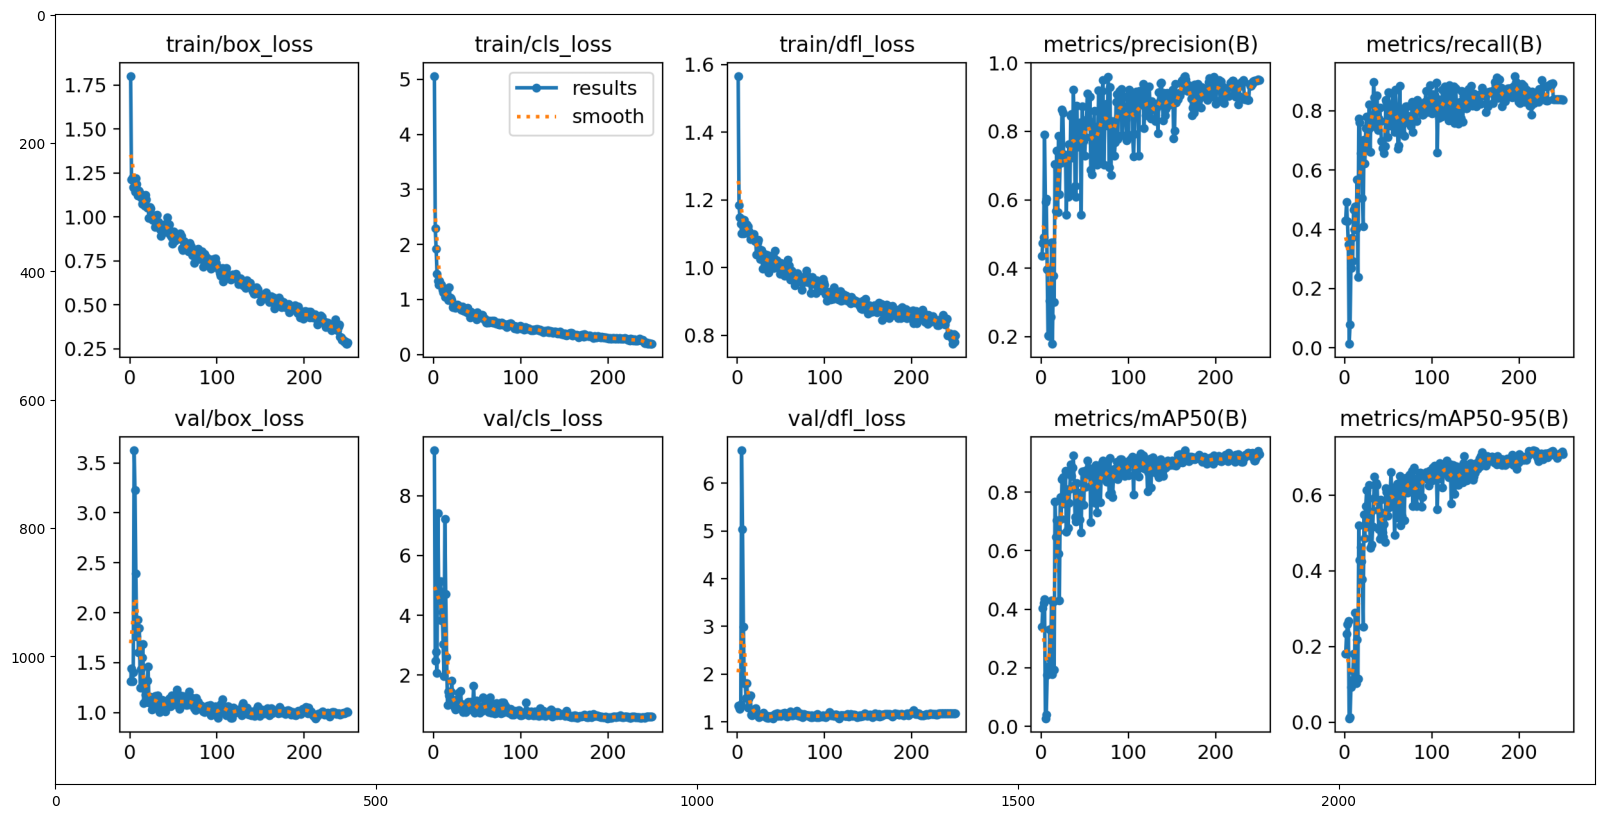

In [15]:
training_output_folder = '/kaggle/working/runs/detect/train'

plt.figure(figsize=(20, 10))
img = Image.open(os.path.join(training_output_folder, 'results.png'))
plt.imshow(img)
plt.show()

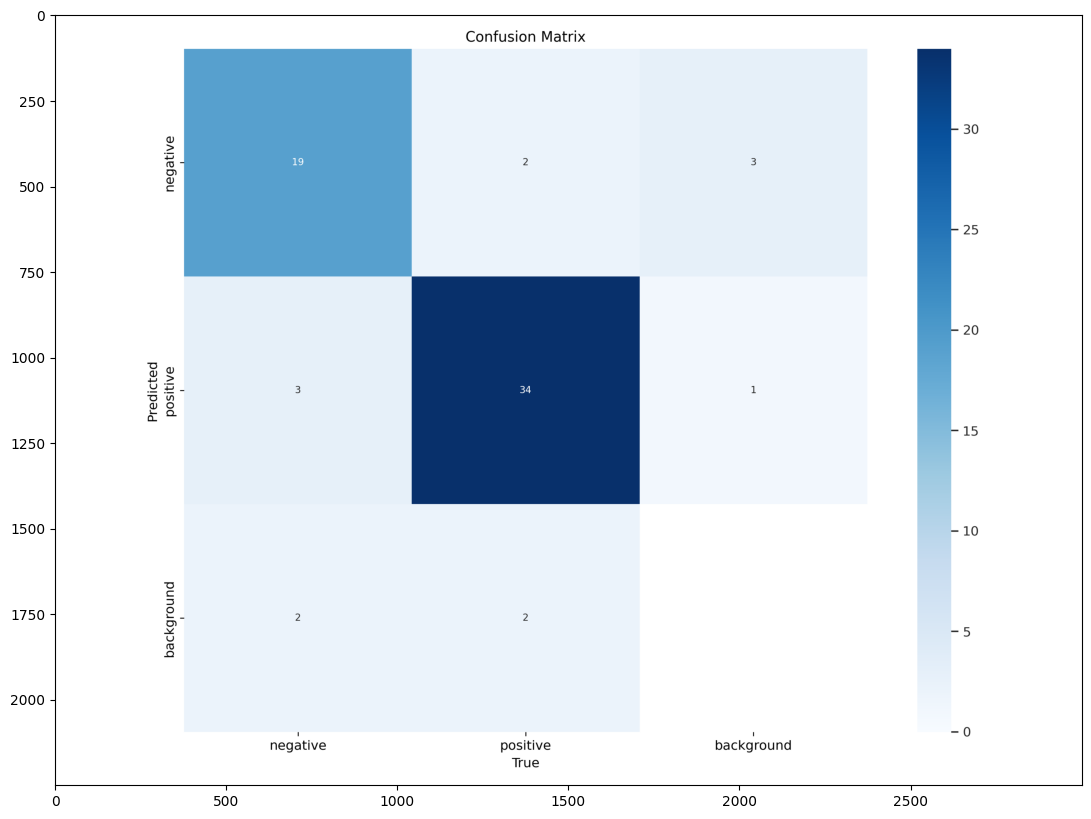

In [16]:
plt.figure(figsize=(20, 10))
img = Image.open(os.path.join(training_output_folder, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

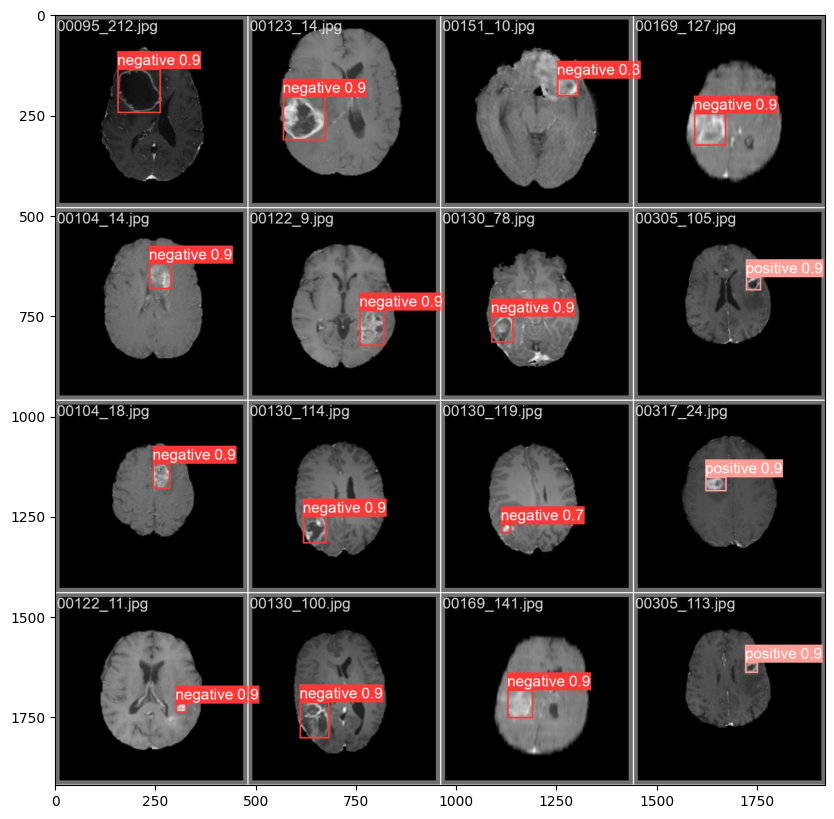

In [17]:
image_path = '/kaggle/working/runs/detect/train/val_batch0_pred.jpg'
plt.figure(figsize=(20, 10))
img = Image.open(image_path)
plt.imshow(img)
plt.show()

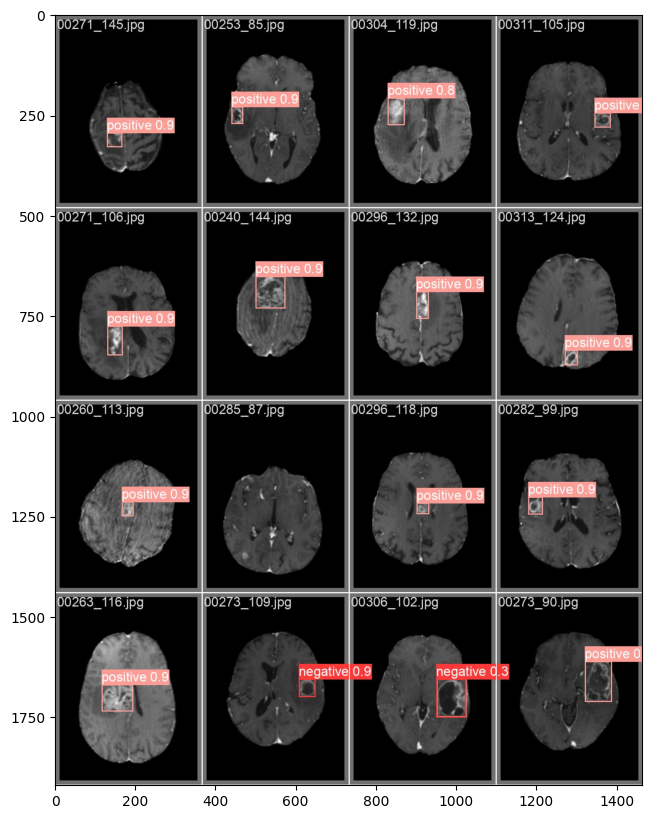

In [18]:
image_path = '/kaggle/working/runs/detect/train/val_batch1_pred.jpg'
plt.figure(figsize=(20, 10))
img = Image.open(image_path)
plt.imshow(img)
plt.show()

In [19]:
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train/weights/best.pt conf=0.25 source="/kaggle/working/dataset/images/test"

Ultralytics YOLOv8.1.37 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs

image 1/75 /kaggle/working/dataset/images/test/00018_101.jpg: 640x640 2 negatives, 7.9ms
image 2/75 /kaggle/working/dataset/images/test/00018_109.jpg: 640x640 1 negative, 8.4ms
image 3/75 /kaggle/working/dataset/images/test/00018_111.jpg: 640x640 2 negatives, 7.9ms
image 4/75 /kaggle/working/dataset/images/test/00018_117.jpg: 640x640 1 negative, 7.9ms
image 5/75 /kaggle/working/dataset/images/test/00018_121.jpg: 640x640 1 negative, 7.9ms
image 6/75 /kaggle/working/dataset/images/test/00018_126.jpg: 640x640 1 negative, 7.9ms
image 7/75 /kaggle/working/dataset/images/test/00018_134.jpg: 640x640 (no detections), 7.9ms
image 8/75 /kaggle/working/dataset/images/test/00019_66.jpg: 640x640 1 negative, 7.9ms
image 9/75 /kaggle/working/dataset/images/test/00019_75.jpg: 640x640 2 negatives, 1 positive, 7.9ms
image 10/75 /ka

### Predicted vs Real

In [20]:
def draw_img_label(img, label, thickness=2):
    x_size, y_size = img.size
    label_text, cx, cy, w, h = label
    cx = cx * x_size
    cy = cy * y_size
    w = w * x_size
    h = h * y_size
    
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx - w/2, cy - h/2), (cx + w/2, cy + h/2)), outline="blue", width=thickness)
    draw.text((cx - w/2, cy - h/2 - 15), str(label_text), fill="red")
    return img

In [21]:
def draw_img_label(img, label, thickness=2):
    x_size, y_size = img.size
    label_text, cx, cy, w, h = label
    cx = cx * x_size
    cy = cy * y_size
    w = w * x_size
    h = h * y_size
    
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx - w/2, cy - h/2), (cx + w/2, cy + h/2)), outline="blue", width=thickness)
    draw.text((cx - w/2, cy - h/2 - 15), str(label_text), fill="red")
    return img

In [22]:
def show_predicted_vs_real(pred_path, real_path, label_path):
    pred_image = Image.open(pred_path)
    real_image = Image.open(real_path)

    with open(label_path, 'r') as f:
        label = tuple(map(float, f.readline().split()))  # Legge le coordinate come float

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(pred_image)
    axes[0].set_title('Predicted Image')
    axes[0].axis('off')

    axes[1].imshow(real_image)
    axes[1].set_title('Real Image')
    image_with_label = draw_img_label(real_image, label)
    axes[1].imshow(image_with_label, cmap='gray')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

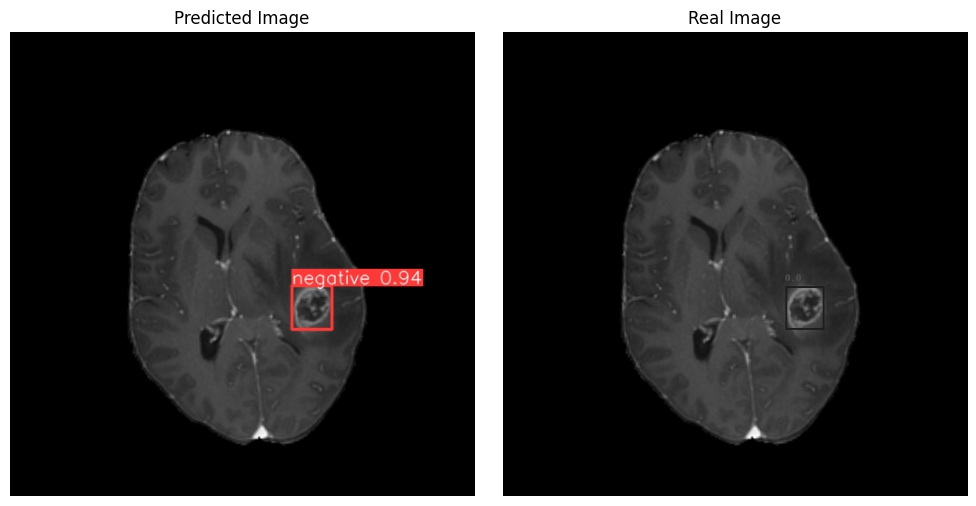

In [23]:
pred_list = os.listdir('/kaggle/working/runs/detect/predict')
image_id = pred_list[2]
# random_images = random.sample(pred_list, 1)

pred_path = os.path.join('/kaggle/working/runs/detect/predict', image_id)
real_path = os.path.join('/kaggle/working/dataset/images/test', image_id)
label_path = os.path.join('/kaggle/working/dataset/labels/test', os.path.splitext(image_id)[0] + '.txt')

show_predicted_vs_real(pred_path,real_path,label_path )

In [24]:
model=YOLO('/kaggle/working/runs/detect/train/weights/best.pt')
results = model.predict(source=real_path, conf=0.25)


image 1/1 /kaggle/working/dataset/images/test/00090_169.jpg: 640x640 1 negative, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


In [25]:
for result in results:
    boxes = result.boxes
bbox = boxes.xyxy.tolist()[0]
print(bbox)

[310.5168151855469, 280.1434020996094, 354.19659423828125, 328.6288757324219]


In [26]:
pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-jk51hzj9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-jk51hzj9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [27]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/bin/bash: {sys.executable}: command not found
--2024-03-29 16:28:41--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.14, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: 'sam_vit_h_4b8939.pth'

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   321MB/s    in 7.7s    

2024-03-29 16:28:49 (319 MB/s) - 'sam_vit_h_4b8939.pth' saved [2564550879/2564550879]



In [28]:
image = cv2.cvtColor(cv2.imread(real_path), cv2.COLOR_BGR2RGB)
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
device = "cuda"
sam.to(device=device)
predictor = SamPredictor(sam)
predictor.set_image(image)

In [29]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

In [30]:
input_box = np.array(bbox)
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

/opt/conda/lib/python3.10/site-packages/segment_anything/modeling/prompt_encoder.py:199: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:71.)
  y_embed = grid.cumsum(dim=0) - 0.5
/opt/conda/lib/python3.10/site-packages/segment_anything/modeling/prompt_encoder.py:200: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:71.)
  x_embed = grid.cumsum(dim=1) - 0.5


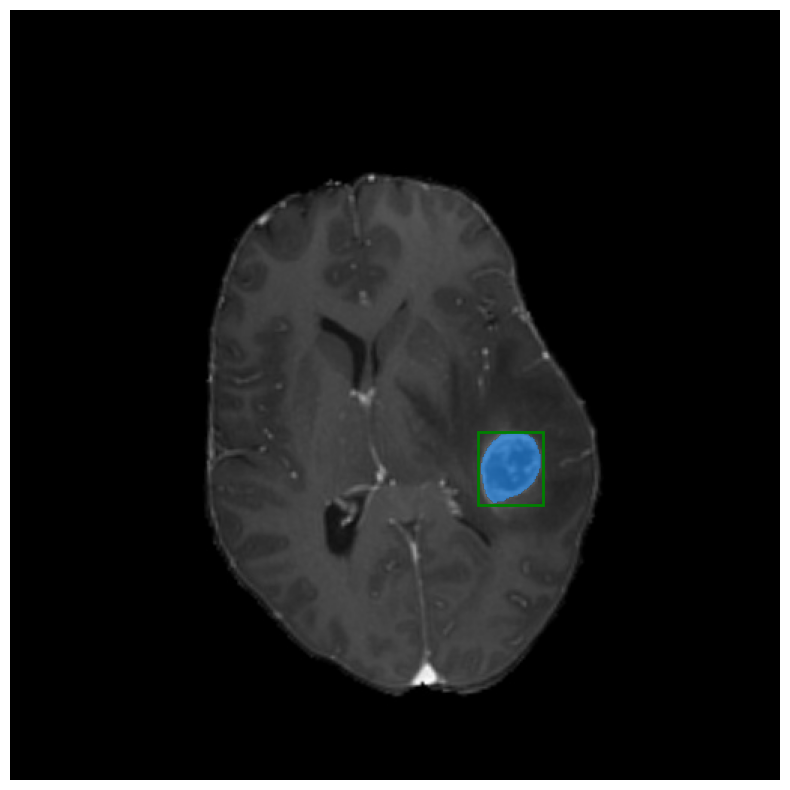

In [31]:
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()